In [1]:
## Import libraries ##
import numpy as np
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd

In [2]:
## Define Basic functions ##

#generate points that aren't too close to each other
def generate_points(minX, maxX, N, dim = 1):
    min_distance = np.abs(maxX-minX)/(2*N)
    print(min_distance)
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(minX, maxX, size=(1,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.abs(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    return np.concatenate(points)


# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()


#squared expo kernel
def kernel(a, b, kernelParameter_l, kernelParameter_sigma):
    #Hyperparameters:
    #kernelParameter_l = 1.94 #0.3 #1.94
    #kernelParameter_sigma = 1.75 #1.0 #1.75
    
    #Kernel:
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqexpo = (kernelParameter_sigma**2)*np.exp(-.5 * (1/(kernelParameter_l**2)) * sqdist)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return sqexpo


# Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
def posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
    '''
    
    N = len(X)
    n = 200 # number of test points X*
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))

    ## 3) Predictive mean at test points
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diag mat since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))
    
    return Xtest, mu, std


#Given test point x (Xtest_val), what is y?
def conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Given test point x (Xtest_val), what is y?
    '''
    N = len(X)
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + sigma_n**2*np.eye(N)) 

    ## 3) Predictive mean at test points
    Xtest = np.asarray([Xtest_val]).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diagonal matrix since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))

    return Xtest_val, mu, std


#plot the posterior distribution of GPR
def plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Plot the posterior distribution of GPR
    '''
    #Return mu and std:
    Xtest, mu, std = posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    print("Mean predictive std: ", np.mean(std))
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'k+', ms=18)
    # Plot test points
    #plt.plot(Xtest, f(Xtest), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest.flat, mu-2*std, mu+2*std, color="#dddddd")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()

In [3]:
## Define Extra Functions ##

#Used for grid optimization of a function within initial bounds (parameters)
def grid(function, init_par, depth = 4, num_points = 100):
    '''
    grid(function, init_par, depth = 4, num_points = 100)
    Used for grid optimization of a function within initial bounds (parameters)
    '''
    
    #assume sigma_n_min = 0
    sigma_n_min = 0.0001
    
    #lists
    l_list = np.linspace(init_par[1] - init_par[1]/1.01, init_par[1]+10*init_par[1], num_points)
    sigma_list = np.linspace(init_par[2] - init_par[2]/1.01, init_par[2]+5*init_par[2], num_points)
    l_plot, sigma_plot = l_list, sigma_list
    z_plot = None
    
    #parameters
    z_min = 0
    l_min = 0
    sigma_min = 0
    
    num_points_depth = num_points #used in loop range calculation. halfs at every iteration

    for count in range(depth):
        #find minimum of objective function
        z_l = []
        for i in range(num_points_depth):
            z_sigma = []
            for j in range(num_points_depth):
                mll = function([sigma_n_min, l_list[i], sigma_list[j]], X, y)[0][0]
                z_sigma.append(mll)
            z_l.append(np.array(z_sigma))
        z_l = np.array(z_l)
        if count == 0:
            z_plot = z_l
        z_min = np.nanmin(z_l)
        l_min_id = np.unravel_index(np.nanargmin(z_l), z_l.shape)[0]
        sigma_min_id = np.unravel_index(np.nanargmin(z_l), z_l.shape)[1]
        l_min, sigma_min = l_list[l_min_id], sigma_list[sigma_min_id]

        #parameter space for the grid
        l_list = np.linspace(l_min-l_min/(2*10**count), l_min+l_min/(2*10**count), num_points)
        sigma_list = np.linspace(sigma_min-sigma_min/(2*10**count), sigma_min+sigma_min/(2*10**count), num_points)
        
        num_points_depth = num_points_depth//2

    if function == "gp_loss_fn":
        #Finish finding a global optimum with a local method:
        new_init_par = [sigma_n_min, l_min, sigma_min]
        opt_par = minimize(gp_loss_fn, new_init_par, args=(X,y), method="Nelder-Mead", options = {'disp':True})
        sigma_n, l, sigma, z = np.abs(opt_par.x[0]), np.abs(opt_par.x[1]), np.abs(opt_par.x[2]), opt_par.fun
        print("Min of obj funct = ", z)
        print("sigma_n = %.7f, l = %.7f, sigma_f = %.7f" % (sigma_n, l, sigma))
    else:
        sigma_n, l, sigma, z = np.abs(sigma_n_min), np.abs(l_min), np.abs(sigma_min), z_min

    return [[sigma_n, l, sigma, z], [z_plot, l_plot, sigma_plot, num_points, function]]



def contour_plot(best_params, init_params):
    '''
    contour_plot(best_params, init_params)
    [sigma_n, l, sigma, z], [l_plot, sigma_plot, num_points, function] = grid(function, init_par, depth = 4, num_points = 100)
    Contour plot of grid().
    '''
    #Contour Plot#
    ##############
    [sigma_n, l, sigma, z], [z_plot, l_plot, sigma_plot, num_points, function] = best_params, init_params

    # Meshgrid of L and Sigma
    L, Sigma = np.meshgrid(l_plot, sigma_plot)

    # plot contour lines
    fig, ax = plt.subplots(1, 1)
    contour_levels = np.concatenate((np.linspace(z,z+1,10),
                                   np.linspace(z+2,z+4,3)))

    cntr = ax.contour(L, Sigma, z_plot, levels = contour_levels)
    fig.colorbar(cntr, ax = ax)
    
    # plot global minimum point
    minpoint = ax.scatter(sigma, l, color='red')
    minpoint.set_zorder(5)

    # plot settings
    ax.set_xlim(4*sigma/5,6*sigma/5)
    ax.set_ylim(4*l/5,6*l/5)

    ax.set_title('Contour plot of Objective Function') 
    ax.set_ylabel(r'$l$') 
    ax.set_xlabel(r'$\sigma_f$') 

    plt.show() 
    
    

def plot3D(best_params, init_params):
    '''
    [sigma_n, l, sigma, z], [l_plot, sigma_plot, num_points, function] = grid(function, init_par, depth = 4, num_points = 100)
    Must be used with grid() function
    '''
    # number of grid points
    [sigma_n, l, sigma, z], [z_plot, l_plot, sigma_plot, num_points, function] = best_params, init_params

    # Meshgrid of L and Sigma
    L, Sigma = np.meshgrid(l_plot, sigma_plot)


    # Render plots
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(L, Sigma, z_plot, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False, alpha = 0.5)
    ax.view_init(20, -30)
    ax.scatter(sigma, l, z, marker = '+', color = "red")
    
    # plot settings
    ax.set_ylabel(r'$l$') 
    ax.set_xlabel(r'$\sigma_f$')

    plt.show() 

## Given

Plot of dataset and the function we'd like to estimate (our goal):

0.5


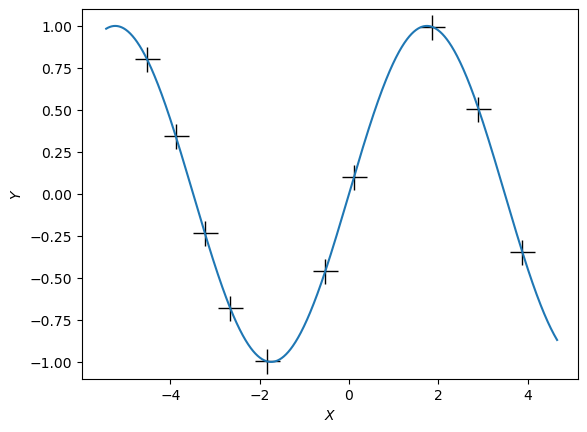

In [4]:
#This is our dataset:
N = 10 
X = generate_points(-5, 5, N, dim = 1)
y = (f(X) + np.random.normal(0,0,N)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#Plot of data:
plt.plot(X, y, 'k+', ms=18)

#Function we'd like to estimate --> our goal
x = np.arange(min(X)-abs(min(X))*0.2, max(X)+abs(max(X))*0.2, 0.01).reshape(-1,1)
f_x = f(x)

#Render plots
plt.plot(x, f_x)
plt.axis([min(x)-abs(min(x))*0.1, max(x)+abs(max(x))*0.1, min(f(x))-abs(min(f(x)))*0.1,  max(f(x))+abs(max(f(x)))*0.1])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

and we'll use this kernel in our GP:

We use the _Squared Exponential Kernel_, also called Radial Basis Function Kernel or Gaussian Kernel, as our covariance function:
\begin{equation}\label{eq:1}
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)
\end{equation}
where the signal variance $\sigma_f^2$ (signal standard deviation $\sigma_f$) and the length scale $l$ are _hyperparameters_ which we'll want to optimize. In this example, this would result in a $n$x$n$ positive-definite covariance matrix $K$ where each element is $\kappa(x_i,x_j)$ with $x_i,x_j$ taken from the $n$ evenly spaced $x$ values for all $i,j\in \{1\ldots,n\}$.

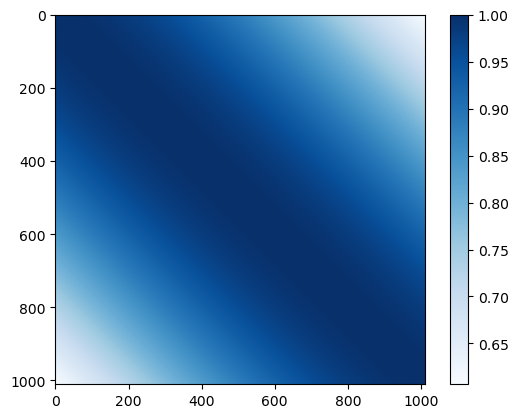

In [5]:
#Plot of kernel
x = x.reshape(-1,1)
x = (x - np.min(x))/(np.max(x) - np.min(x)) #X in [0,1]
K = kernel(x, x, 1, 1)

plt.imshow(K, cmap = 'Blues', interpolation = 'nearest')
plt.colorbar()
plt.show()

## 4 Covariance Functions

A covariance function (kernel) defines the covariance of the GP random variables. Kernel and mean function together define a GP. For a kernel $K$ to be valid, it must be positive definite. That is, it satisfies the property that $y^TKy>0$ for all $y\in R^N$ where $y$ isa a $n$x1 vector. This implies that $K$ must be a symmetric matrix and that it must be invertible.
- _Stationary_ covariance function is a function $x-x'$. It is invariant to translations in input space. Ex: squared exponential kernel.
- _Isotropic_ covariance function if it is a function of $\lvert x-x' \rvert$. Ex: squared exponential kernel.
- _Dot product_ covariance function if it depends only on $x$ and $x'$ through $x\cdot x'$. Ex: $k(x,x') = \sigma_0^2 + x\cdot x'$ from linear regression with $N(0,1)$ priors on the coefficients of $x_d$ and a prior of $N(0,\sigma_0^2)$ on the bias $1$. Another is the polynomail kernel $k(x,x') = (\sigma_0^2+x\cdot x')^p$. They're invariant to rotation of coordinates but not translations.
- _Gram matrix, or covariance matrix, K_ whose entries are $K_{ij} = k(x_i,x_j)$. It is a positive semidefinite matrix.

Multiplying two kernels $K_1$ and $K_2$ together performs elementwise multiplication resulting in a new kernel $K=K_1K_2$ that will only have an element with a high value if $K_1$ and $K_2$ have high valued elements. This can be interpreted as an AND operation. Likewise, addition of two kernels can be interpreted as an OR operation, since either $K_1$ or $K_2$ has to have a high value element for $K=K_1+K_2$ to have a high value element.

## 5 Model Selection and Adaptation of Hyperparameters

Families of covariance functions have _hyperparameters_ whose values we must determine. This is _model selection_. The _training_ of a GP is the process of selecting a covariance function's parameters.

**Feature Scaling**

Before we begin our optimization, it's important to normalize our parameters. To normalize means to multiply a variable by a factor that makes the norm or integral equal to 1. In statistics, this method is called _feature scaling_ or _data normalization_, which normalizes the range of independent variables (features) of data. The motivation behind feature scaling is to ensure that each feature contributes proportionally to the final distance, should one feature have a broader range of values that will have a greater effect on the distance. Another motivation is that gradient descent methods converge faster.

Technique: _Rescaling (min-max normalization)_:

For min-max of $[0,1]$,
$$x' = \frac{x - min(x)}{max(x) - min(x)}$$

Sources used:
* https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)

Normalize data:

In [6]:
#Normalize feature:
X = (X - np.min(X))/(np.max(X) - np.min(X)) #X in [0,1]

#Normalize target:
#y = (y - min(y))/(max(y)-min(y))

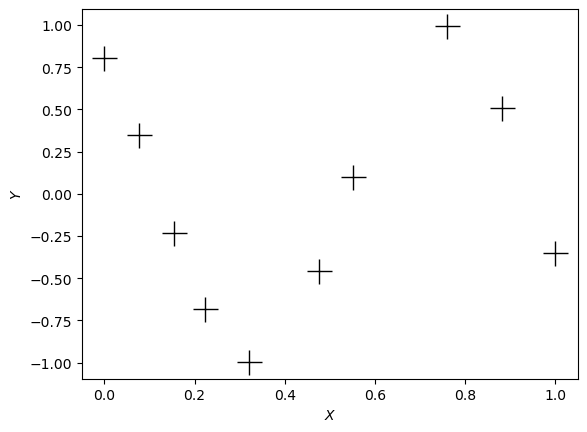

In [7]:
#Plot
plt.plot(X, y, 'k+', ms=18) #data points

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

**Choosing initial parameters**

We first need to choose a set of initial parameters for our optimization method. In general, the marginal likelihood of a GP is a non-convex objective function. Since the starting point of gradient-based and simplex-based optimization methods determine the end point, it is possible that those methods find a local, but not global, minimum.

We can approximate the signal standard deviation with half the range of the observations $y$: $\sigma_f \approx \frac{\lvert\text{min}_y\rvert+\lvert\text{max}_y\rvert}{2}$.

Now we want to find an approximation for the length scale. Since we've scaled the data, if the data oscillates then we know that $l$ must lie between $0$ and $1$, so let's choose $l = 0.5$. If the data does not oscillate, then $l\geq 1$.

If we have no prior knowledge on the nature of the data, we can at least be sure that the observation noise standard deviation must be less than the standard deviation of $y$. For our purposes, we know that it must be $0$. We thus use these two approximations as initial parameter choices for $\sigma_f$ and $\sigma_n$. 

In [8]:
#Initial guesses#
init_sigma_n = 0.0001 #np.std(y) # guess for observation noise
init_len_scale = 0.5
init_sigma_f = (np.abs(np.min(y)) + np.abs(np.max(y)))/2 #this is the semi-range

init_par = [init_sigma_n, init_len_scale, init_sigma_f]
init_par #these are the optimum parameters

[0.0001, 0.5, 0.9956040175603238]

### 5.3 Method 2: Leave-one Out Cross-validation

 _Cross validation (CV)_ for model selection: split the training set $X$ into two disjoint sets, one set is used for training, and the other is called the validation set which is used to judge the performance. The performance on the validation set approximates the generalization error. Since the performance estimate from the validation set may have large variance, we use _k-fold CV_: the data is partitioned into $k$ subsets (folds) where validation is done on a single subset and training is done on the union of the $k-1$ remaining subsets. The procedure is repeated $k$ times, each time with a different subset for validation.
 
If $k = n$, the number of training cases, then we have _leave-one-out CV (LOO-CV)_. CV can be used with any loss function with the _squared error loss_ $(y_i - \mu_i)^2$ being the most common for regression. For probabilistic models such as GPs, we can also use the _negative log probability loss_. In GPR, the predictive log probability when leaving out training case $i$ is:
$$
\log p(y_i\vert X,y_{-i},\theta) = -\frac{1}{2}\log\sigma_i^2 - \frac{(y_i - \mu_i)^2}{2\sigma_i^2} - \frac{1}{2}\log 2\pi
$$
where $y_{-i}$ means all targets except number $i$, so the training sets are $(X_{-i},y_{-i})$. The LOO log predictive probability is:
$$
L_{\text{LOO}}(X,y,\theta) = \sum_{i=1}^n\log p(y_i\vert X,y_{-i},\theta)
$$
Then $-L_{\text{LOO}}(X,y,\theta)$ is the _negative log predictive probability/density (NLPD)_, which measures the error between a model's predictions and true values. A smaller error is better.
<br><br><br>
Sources use:
 * Rassmussen et al. pg 111
 * https://en.wikipedia.org/wiki/Negative_log_predictive_density
 * https://medium.com/@avijit.bhattacharjee1996/implementing-k-fold-cross-validation-from-scratch-in-python-ae413b41c80d 

In [21]:
#function to divide the data
def kfold_indices(data,k):
    fold_size = len(data)//k #floor division
    indices = np.arange(len(data))
    folds = []
    for i in range(k):
        validation_indices = indices[i*fold_size : (i+1)*fold_size] #single subset
        train_indices = np.concatenate([indices[ : i*fold_size], indices[(i+1)*fold_size : ]]) #union of k-1 remaining subsets
        folds.append((train_indices, validation_indices))
    return folds

fold_indices = kfold_indices(X,N) #k = N is LOO CV. Can input either X or y --> (x_i,y_i)

In [22]:
def accuracy_score(y_test, mu_pred, std_pred): #loss function
    y_test = y_test[0][0]
    mu_pred = mu_pred[0][0]
    std_pred = std_pred[0]
    
    #prob = -(1/2)*np.log(std_pred**2) - (y_test - mu_pred)**2/(2*std_pred**2) - (1/2)*np.log(2*np.pi)
    prob = -1*(y_test - mu_pred)**2 #squared error loss
    return prob


def kfold_score(par,X,y):
    sigma_n, l, sigma_f = par #noise std, lengthscale l, and signal std
    
    #Initialize a list to store the evaluation scores
    scores = []
    
    #Iterate through each fold
    for train_indices, validation_indices in fold_indices:
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[validation_indices], y[validation_indices]
        
        #Using the training model, make predictions on the test data
        Xtest_val, mu_pred, std_pred = conditional(X_test, X_train, y_train, sigma_n, l, sigma_f)
        
        #Calculate the accuracy score for this fold
        fold_score = accuracy_score(y_test, mu_pred, std_pred)
        
        #Append the fold score to the list of scores
        scores.append(fold_score)
        
    sum_accuracy = -1*np.sum(scores) #(Negative) LOO log predictive probability (or density) --> NLPD
    
    return [[sum_accuracy]]

#### Strategy 1) Grid method for LOO CV

Min of loss funct =  0.0011935825015469503
sigma_n = 0.000100, l = 0.504500, sigma_f = 4.144435
Mean predictive std:  0.0010040754126347784


<Figure size 640x480 with 0 Axes>

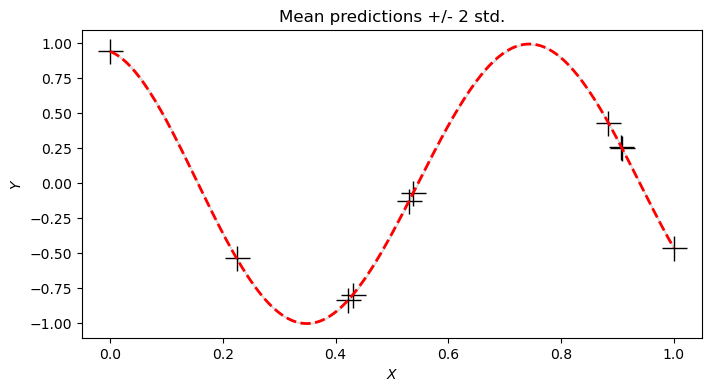

In [24]:
[[sigma_n, l, sigma, z], [z_plot, l_plot, sigma_plot, num_points, function]] = grid(kfold_score, init_par, depth = 1, num_points = 100)
print("Min of loss funct = ", z)
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plot_post(X, y.T[0], sigma_n, l, sigma)

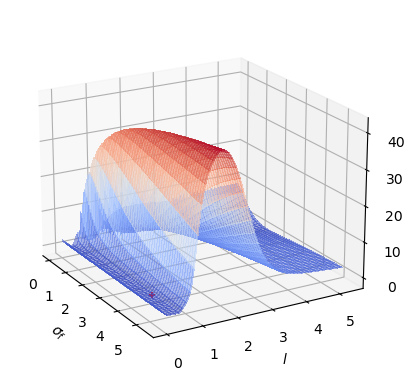

In [25]:
plot3D([sigma_n, l, sigma, z], [z_plot, l_plot, sigma_plot, num_points, function])

### 5.4 Method 3: Marginal likelihood

Definitions
* _Likelihood_: let $p(x\vert \theta)$ be the density function of $x$ with a fixed $\theta$, and $x$ is a realization of the random variable $X$. The likelihood function $L(\theta\vert x) = p_\theta(x)$ is a function of $\theta$, the probability of $x$ for the parameter $\theta$. It is not a pdf. 
* _Maximum likelihood estimator (MLE)_: this is the value of $\theta$ that has the highest chance of obtaining sample $X$. That is, $\hat{\theta} = \text{argmax}_\theta L(\theta\vert x)$. If $\theta = (\theta_1,\theta_2)$, we can find $\hat{\theta} = (\hat{\theta_1},\hat{\theta_2})$ by solving $\frac{d}{d\theta_j}\ln(L(\theta\vert x))=0$.

In context of GPs:
* _Marginal likelihood (evidence)_: $p(y\vert X) = \int p(y\vert f,X)p(f\vert X) df$ (#) where the left integrand $p(y\vert f,X) = L(y\vert f,X)$ is the likelihood and the right is the pdf of the prior. The term marginal refers to the marginalization over $f$. From Bayes' rule, we have 
$$p(f\vert y, X) = \frac{p(y\vert f,X)p(f\vert X)}{p(y\vert X)} = \frac{p(y\vert f,X)p(f\vert X)}{\int p(y\vert f,X)p(f\vert X) df}$$
where the denominator is a direct application of the _law of total probability_, expressing the total probability of outcome realized over distinct events. This is expressed as a weighted average $p(y) = \sum_n p(y\cap f_n) = \sum_n p(y\vert f)p(f)$ if $f$ is discrete, or as $p(y) = \int_{-\infty}^{\infty} p(y\vert F=f)p_F(f) df$ if $f$ is continuous. A marginal distribution, unlike a conditional distribution contingent upon other variables, returns a probability of a subset of a collection of random variables (like the marginal of $X$ in a joint distribution $X,Y$).
<br><br>
* Note that $f\vert X\sim N(0,K)$, $y\vert f \sim N(f,\sigma_n^2I)$, and $y\sim N(0,K+\sigma_n^2I)$ by property of marginal distribution of joint Normal (see definition of GP). We make use of these facts to perform the integration of (#), yielding the maringal likelihood
$$
p(y\vert X) = (2\pi)^{\frac{-n}{2}}\lvert (K+\sigma_n^2I)\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^T(K+\sigma_n^2I)^{-1}y]
$$
and we take the log to get the log marginal likelihood
$$
\ln(p(y\vert X)) = -\frac{n}{2}\ln(2\pi)-\frac{1}{2}\ln\lvert (K+\sigma_n^2I)\rvert-\frac{1}{2}y^T(K+\sigma_n^2I)^{-1} y.
$$
<br><br>
* We have $m$ hyperparameters $\theta = (\theta_1,\ldots,\theta_m)$ in our GP model based on observations $(X,y)$, and the covariance function $K$ is a function of $\theta$, so we write the marginal likelihood conditioned on the hyperparameters $\theta$. Now our goal is to maximize the marginal likelihood $p(y\vert X,\theta)$, where $\theta$ is unknown, based on the observed data $(X,y)$. That is, we want to find the _maximum marginal likelihood_
$$
\hat{\theta} = \text{argmax}_\theta p(y\vert X,\theta)
$$
Let's write $y\sim N(0,K+\sigma_n^2I) = N(0,K_y)$, where $K = k(X,X)$ and $K_y$ depend on $X,\theta$ (for $K_y$, $\theta$ includes $\sigma_n$). Then,
$$
p(y\vert X,\theta) = (2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y]
$$
which we rewrite as the marginal log-likelihood
$$
\ln(p(y\vert X,\theta)) = -\frac{n}{2}\ln(2\pi)-\frac{1}{2}\ln\lvert K_y\rvert-\frac{1}{2}y^TK_y^{-1} y.
$$
<br><br>
To optimize the marginal log-likelihood, we have make it an objective function by taking the negative as such: $J(\theta) =  -\ln(p(y\vert X,\theta))$, that way we have a minimization problem.
<br><br>
Sources used: 
* Rasmussen and Williams, _Gaussian Process for Machine Learning_; pp. 19, 115
* https://math.stackexchange.com/questions/3954080/explanation-of-marginal-likelihood-in-gaussian-process

In [59]:
# Negative Marginal log-likelihood of the GP we would like to optimize
def gp_loss_fn(par,X,y): #input observations (X,y) and initial parameters (guess)
    sigma_n, l, sigma = par #noise std, lengthscale l, and signal std
    N = len(X)
    
    K_y = kernel(X, X, l, sigma) + (sigma_n**2)*np.eye(N)
    K_y_inverse = np.linalg.inv(K_y)
    
    #negative marginal log-likelihood
    mll = (N/2)*np.log(2*np.pi) + (1/2)*np.log(np.linalg.det(K_y)) + (1/2)*np.dot(np.dot(y.T,K_y_inverse),y)
    return mll #this is our objective function

In [9]:
# Negative Marginal log-likelihood of the GP we would like to optimize (modified to allow focus on particular hyperparams)
def gp_loss_fn_focus(sigma_n, l, sigma, X, y): #input observations (X,y) and initial parameters (guess)
    N = len(X)
    
    K_y = kernel(X, X, l, sigma) + (sigma_n**2)*np.eye(N)
    K_y_inverse = np.linalg.inv(K_y)
    
    #negative marginal log-likelihood
    mll = (N/2)*np.log(2*np.pi) + (1/2)*np.log(np.linalg.det(K_y)) + (1/2)*np.dot(np.dot(y.T,K_y_inverse),y)
    return mll #this is our objective function

**Finding the gradients**

To find $\text{argmax}_\theta p(y\vert X,\theta)$, we find the $\theta_j$s that maximize the marginal log-likelihood:
$$\frac{d}{d\theta_j}\ln p(y\vert X,\theta) = \frac{1}{2}y^TK_y^{-1}y\frac{dK_y}{d\theta_j}K_y^{-1}y - \frac{1}{2}\text{tr}\left(K_y^{-1}\frac{dK_y}{d\theta_j} \right)$$
$$=\frac{1}{2}\text{tr}\left((\alpha\alpha^T - K_y^{-1})\frac{dK_y}{d\theta_j} \right)$$
where $\alpha = K_y^{-1}y$ and $\text{tr}(\cdots)$ is the trace of a square matrix (sum of elements on the matrix's main diagonal). In practice, we want to optimize the objective function $\hat{\theta} = \text{argmin}_\theta -\ln(p(y\vert X,\theta))$, turning our goal from a maximazation to a minimization problem. In this case we want to find the $\theta_j$ that minimize the negative marginal log-likelihood:
$$\frac{d}{d\theta_j}-\ln p(y\vert X,\theta) = -\frac{1}{2}y^TK_y^{-1}y\frac{dK_y}{d\theta_j}K_y^{-1}y + \frac{1}{2}\text{tr}\left(K_y^{-1}\frac{dK_y}{d\theta_j} \right)$$
$$=-\frac{1}{2}\text{tr}\left((\alpha\alpha^T - K_y^{-1})\frac{dK_y}{d\theta_j} \right)$$

For the squared exponential kernel with noise parameter $\sigma_n$, $K_y = K+\sigma_nI$ with hyperparameters $\theta = \{\sigma_n,l,\sigma_f\}$.
$$
\kappa_y(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)
  + \sigma_n^21(\mathbf{x}_i = \mathbf{x}_j)
$$
where $1(\cdots)$ is the inicator function.

<br><br><br>
Then,
$$
\frac{dK_y}{d\sigma_n} = 2\sigma_n1(\mathbf{x}_i = \mathbf{x}_j)
$$
so
$$
\frac{d}{d\sigma_n}-\ln p(y\vert X,\theta) = -\frac{1}{2}\text{tr}\left((\alpha\alpha^T - K_y^{-1}) 2\sigma_n\right)
$$

<br><br><br>
Then,
$$
\frac{dK_y}{dl} = (\mathbf{x}_i - \mathbf{x}_j)^T(\mathbf{x}_i - \mathbf{x}_j)\frac{\sigma_f^2}{l^3}\exp\left(-\frac{1}{2l^2}(\mathbf{x}_i - \mathbf{x}_j)^T(\mathbf{x}_i - \mathbf{x}_j)\right)
$$
so
$$
\frac{d}{dl}-\ln p(y\vert X,\theta) = -\frac{1}{2}\text{tr}\left((\alpha\alpha^T - K_y^{-1}) (\mathbf{x}_i - \mathbf{x}_j)^T(\mathbf{x}_i - \mathbf{x}_j)\frac{\sigma_f^2}{l^3}\exp\left(-\frac{1}{2l^2}(\mathbf{x}_i - \mathbf{x}_j)^T(\mathbf{x}_i - \mathbf{x}_j)\right)\right)
$$

<br><br><br>
And then,
$$
\frac{dK_y}{d\sigma_f} = 2\sigma_f\exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)
$$
so
$$
\frac{d}{d\sigma_f}-\ln p(y\vert X,\theta) = -\frac{1}{2}\text{tr}\left((\alpha\alpha^T - K_y^{-1}) 2\sigma_f\exp\left(-\frac{1}{2l^2}(\mathbf{x}_i - \mathbf{x}_j)^T(\mathbf{x}_i - \mathbf{x}_j)\right)\right)
$$

In [61]:
def mll_gradient(par, X, y):
    sigma_n, l, sigma_f = par
    #Setup
    sqdist = np.sum(X**2,axis=1).reshape(-1,1) + np.sum(X**2,1) - 2*np.dot(X, X.T)
    K_y = kernel(X, X, l, sigma) + (sigma_n**2)*np.eye(N)
    K_y_inverse = np.linalg.inv(K_y)
    alpha = np.dot(K_y_inverse,y)
    
    #d_sigma_n
    #Partial derivative of K w/ respect to sigma_n:
    K_diff = 2*sigma_n*np.eye(N)*0
    #Partial derivative of MLL:
    d_sigma_n = -(1/2)*np.trace(np.dot((np.dot(alpha,alpha.T) - K_y_inverse),K_diff))
    
    #d_l
    #Partial derivative of K w/ respect to l:
    K_diff = sqdist*(sigma_f**2/l**3)*np.exp(-.5 * (1/(l**2)) * sqdist)
    #Partial derivate of MLL:
    d_l = -(1/2)*np.trace(np.dot((np.dot(alpha,alpha.T) - K_y_inverse),K_diff))
    
    #d_sigma_f
    #Partial derivative of K w/ respect to sigma_f:
    K_diff = 2*sigma_f*np.exp(-.5 * (1/(l**2)) * sqdist)
    #Partial derivate of MLL:
    d_sigma_f = -(1/2)*np.trace(np.dot((np.dot(alpha,alpha.T) - K_y_inverse),K_diff))
    
    return np.array([d_sigma_n, d_l, d_sigma_f])

#### Strategy 1) Gradient-based approach

_Objective function_: a function whose value is to be minimized or maximized. If we are minimizing it, we can also call it a _cost_, _loss_, or _error_ function.

_Gradient descent_: a method in optimization used for finding a local minimum of a differentiable multivariate function, like a cost or loss function in machine learning, by stepping in the direction of the gradient. Let $J(\theta) =  -\ln(p(y\vert X,\theta))$ be the objective function we want to minimize by updating $\theta$ in the oppositive direction of the gradient of $J(\theta)$, which we write as $\nabla_\theta J(\theta)$. Let $\eta$ determine the number of steps to reach the minimum, the learning rate.

Start with an initial parameter $\theta = \theta_1$. There are three gradient descent methods: 
* 1) _Batch gradient descent (vanilla update)_ computes the graident of the cost (objective) function with respect to $\theta$ for all the training observations $(X,Y)$
$$\theta_{i+1} = \theta_i - \eta\dot\nabla_{\theta_i} J(\theta_i)$$
* 2) _Stochastic gradient descent (SGD)_ updates $\theta_i$ by computing the gradient for only one randomly chosen data point $(x,y)$.
* 3) _Mini-batch SGD_ computes the gradient for a subset (mini-batch) of the dataset to find the gradient.

<br><br>

Sources used:
* https://arxiv.org/pdf/2205.00832.pdf
* Ch. 2 Gradient Descent

Let's use a mini-batch SGD to train the hyperparameters $\theta$. $\theta$ includes the lengthscale $l$ and signal variance $\sigma_f^2$ hyperparameters, as well as the observation noise variance $\sigma_n^2$.

We use an _Adam optimizer_ to perform the mini-batch SGD method. The Adam algorithm is a gradient-based optimizer of stochastic objective functions that adapts its estimation of first and second order moments, making it computationally more efficient.

Sources used: 
* https://arxiv.org/pdf/1412.6980.pdf

In [ ]:
# Strategy method 1) mini-batch SGD
#https://ryancheunggit.gitbooks.io/tfbook/content/chapter4.html#mv

Vanilla gradient descent is a first-order optimization method, since it uses the gradient, to find the minimum. To improve efficiency, we look into second-order methods.

_Newton's method_: in $n$ dimensions, we have this iterative method:
$$\theta_{i+1} = \theta_{i} - [H(\theta_{i})]^{-1}\nabla J(\theta_i)$$
Pitfalls: sensitive to initial conditions and expensive to compute $H$.

Observing how efficient second-order optimization methods are but how inefficient it is to compute the inverse Hessien matrix, we seek a hybrid method of Newton's method and Gradient descent - _quasi-Newton methods_. In these methods we approximate the Hessien matrix, and the method of updating it at each iteration depends on the algorithm we use. For example, there is the secent method in one dimension where we replace the second derivative with its finite difference approximation. For $n$ dimensions, we resort to other methods like the _BFGS algorithm_.

Sources used: 
* https://arxiv.org/pdf/1401.7625.pdf

**Strategy method 2.1)** Finite difference method: L-BFGS-B (variation of gradient-descent method)

Number of iterations =  37
Min of obj funct =  -11.810104086676066
sigma_n = 0.000000, l = 0.389604, sigma_f = 2.261576
Mean predictive std:  1.5613610542585013e-05


<Figure size 640x480 with 0 Axes>

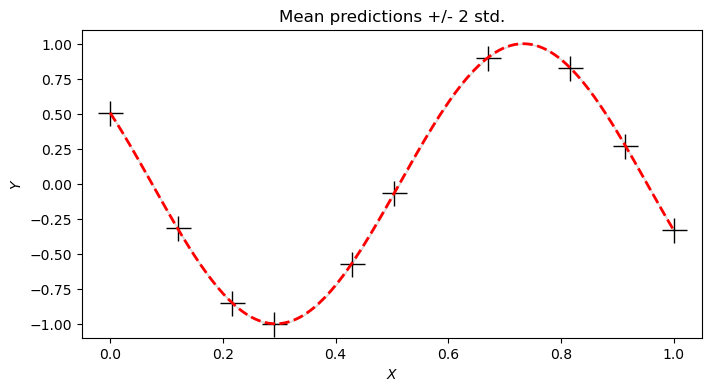

In [62]:
#Optimize all 3 hyperparams
opt_par = minimize(gp_loss_fn, init_par, args=(X,y), method="L-BFGS-B", options = {'disp':True})
print("Number of iterations = ",opt_par.nit)
sigma_n, l, sigma, z = np.abs(opt_par.x[0]), np.abs(opt_par.x[1]), np.abs(opt_par.x[2]), opt_par.fun
print("Min of obj funct = ", z)
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plot_post(X, y.T[0], sigma_n, l, sigma)

Number of iterations =  1
Min of obj funct =  11.095484831586585
sigma_n = 0.000100, l = 0.000608, sigma_f = 0.995604
Mean predictive std:  0.9840720806908676


<Figure size 640x480 with 0 Axes>

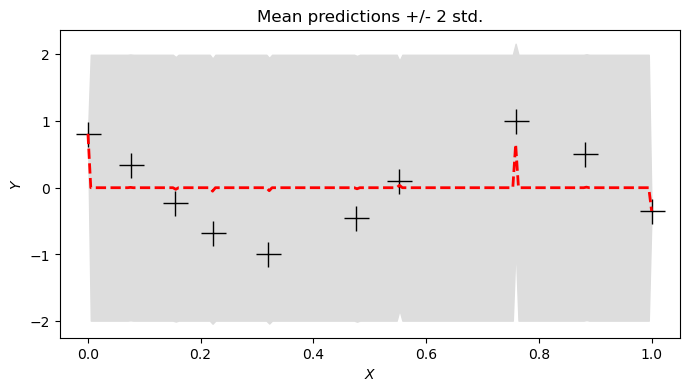

In [10]:
#Optimize l only

#Fix unwanted hyperparameters
sigma_n = init_par[0]
sigma = init_par[2]

#Define wrapper function to optimize l
def wrapper_l(l, X, y, sigma_n = sigma_n, sigma = sigma):
    return gp_loss_fn_focus(sigma_n, l, sigma, X, y)

#Initial guess for l
l0 = init_par[1]

opt_par = minimize(wrapper_l, l0, args=(X,y), method="L-BFGS-B", options = {'disp':True})
print("Number of iterations = ",opt_par.nit)
sigma_n, l, sigma, z = np.abs(init_par[0]), np.abs(opt_par.x[0]), np.abs(init_par[2]), opt_par.fun
print("Min of obj funct = ", z)
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plot_post(X, y.T[0], sigma_n, l, sigma)

Number of iterations =  9
Min of obj funct =  -5.670663834379933
sigma_n = 0.000100, l = 0.500000, sigma_f = 8.620961
Mean predictive std:  0.0001296673811615023


<Figure size 640x480 with 0 Axes>

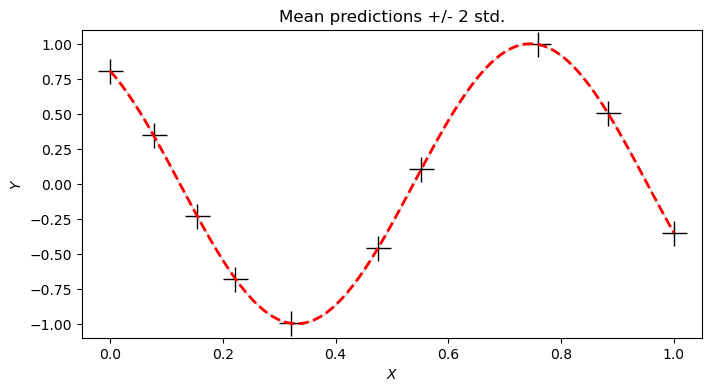

In [11]:
#Optimize sigma only

#Fix unwanted hyperparameters
sigma_n = init_par[0]
l = init_par[1]

#Define wrapper function to optimize l
def wrapper_sigma(sigma, X, y, sigma_n = sigma_n, l = l):
    return gp_loss_fn_focus(sigma_n, l, sigma, X, y)

#Initial guess for l
sigma0 = init_par[2]

opt_par = minimize(wrapper_sigma, sigma0, args=(X,y), method="L-BFGS-B", options = {'disp':True})
print("Number of iterations = ",opt_par.nit)
sigma_n, l, sigma, z = np.abs(init_par[0]), np.abs(init_par[1]), np.abs(opt_par.x[0]), opt_par.fun
print("Min of obj funct = ", z)
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plot_post(X, y.T[0], sigma_n, l, sigma)

Number of iterations =  13
Min of obj funct =  -11.41700860327462
sigma_n = 0.000100, l = 0.366616, sigma_f = 1.911686
Mean predictive std:  0.00012873521549945004


<Figure size 640x480 with 0 Axes>

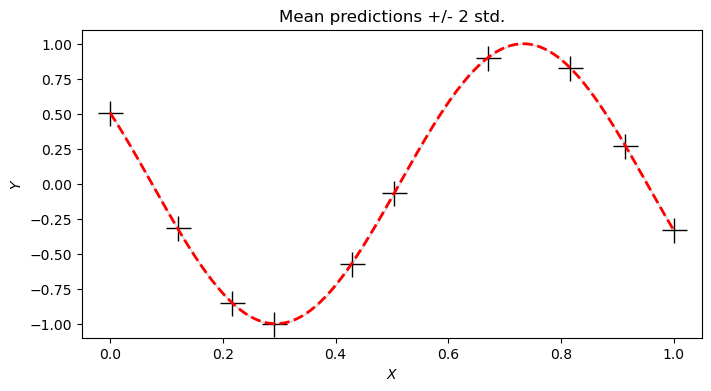

In [72]:
#Optimize l and sigma only

#Fix unwanted hyperparameters
sigma_n = init_par[0]

#Define wrapper function to optimize l
def wrapper(params, X, y, sigma_n = sigma_n):
    l, sigma = params
    return gp_loss_fn_focus(sigma_n, l, sigma, X, y)

#Initial guess for l and sigma
params0 = [init_par[1], init_par[2]]

opt_par = minimize(wrapper, params0, args=(X,y), method="L-BFGS-B", options = {'disp':True})
print("Number of iterations = ",opt_par.nit)
sigma_n, l, sigma, z = np.abs(init_par[0]), np.abs(opt_par.x[0]), np.abs(opt_par.x[1]), opt_par.fun
print("Min of obj funct = ", z)
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plot_post(X, y.T[0], sigma_n, l, sigma)

**Strategy method 2.2)** Input exact (analytical) gradients: L-BFGS-B (variation of gradient-descent method)

Number of iterations =  8
Min of obj funct =  -17.239192138698844
sigma_n = 0.000100, l = 0.236553, sigma_f = 0.962662
Mean predictive std:  0.006189369010465634


<Figure size 640x480 with 0 Axes>

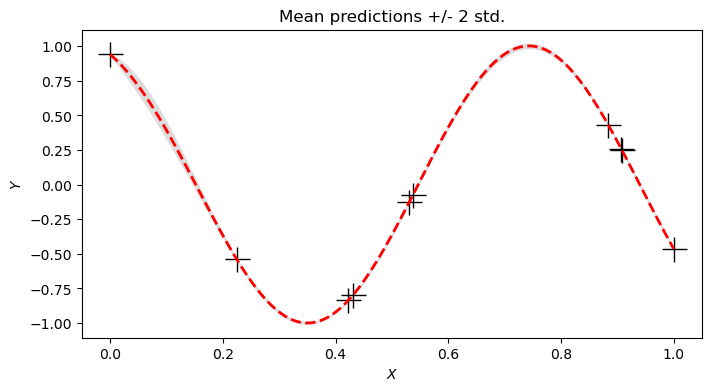

In [29]:
opt_par = minimize(gp_loss_fn, init_par, args=(X,y), method="L-BFGS-B",
                   jac = mll_gradient, options = {'disp':True})
print("Number of iterations = ",opt_par.nit)
sigma_n, l, sigma, z = np.abs(opt_par.x[0]), np.abs(opt_par.x[1]), np.abs(opt_par.x[2]), opt_par.fun
print("Min of obj funct = ", z)
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plot_post(X, y.T[0], sigma_n, l, sigma)

#### Strategy 2) Simplex-based approach

Unlike a gradient descent approach, the _Nelder-Mead method_ is a _simplex method_ for finding a local minimum of a function of multiple variables. A simplex method is a function with several constraints which defines a polynomial (simplex) region and the solution is at one of the verticies, and it systematically tests vertices as possible solutions for each iteration of the method. In Nelder-Mead, a simplex is a triangle and the search pattern compares function valuues at three vertices of the triangle. The vertex with the largest value is rejected and replaced with a new vertex, and the search continues. Eventually the vertices become smaller and the triangles are reduced to vertices around the minimum point.

Sources used: 
* https://jasoncantarella.com/downloads/NelderMeadProof.pdf

Optimization terminated successfully.
         Current function value: -22.726976
         Iterations: 201
         Function evaluations: 438
Number of iterations =  201
Min of obj funct =  -22.726976309119877
sigma_n = 0.000000, l = 0.370388, sigma_f = 3.014673
Mean predictive std:  0.000284883702670275


<Figure size 640x480 with 0 Axes>

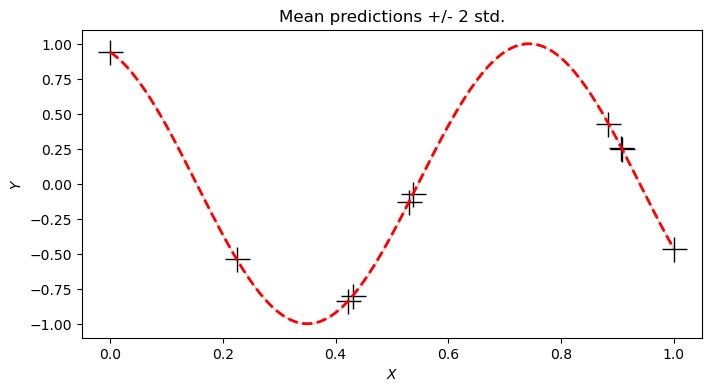

In [30]:
# Nelder-Mead
opt_par = minimize(gp_loss_fn, init_par, args=(X,y), method="Nelder-Mead", options = {'disp':True})
print("Number of iterations = ",opt_par.nit)
sigma_n, l, sigma, z = np.abs(opt_par.x[0]), np.abs(opt_par.x[1]), np.abs(opt_par.x[2]), opt_par.fun
print("Min of obj funct = ", z)
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plot_post(X, y.T[0], sigma_n, l, sigma)

#### Strategy 3) Multistart method for the negative marginal log likelihood

Running the risk of finding local minima, there are two approaches we can take for a gradient based approach: (1) add a momentum term to the gradient descent method such that the momentum would all the method to "roll away" from the shallow local minimum, or (2) do a gradient descent method multiple times with varying starting positions and chose the one that minimimizes the objective function. We try (2).

In [31]:
def multistart(fun, x0min, x0max, N, full_output = False, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None):
    res_list = np.empty(N, dtype = object)
    for i in range(N):
        x0 = np.random.uniform(x0min, x0max)
        res = minimize(fun, x0, args, method, jac, hess, hessp, bounds, constraints, tol, callback, options)
        res_list[i] = res
    sort_res_list = res_list[np.argsort([res.fun for res in res_list])]
    if full_output:
        return sort_res_list[0], sort_res_list
    else:
        return sort_res_list[0]
    
#Source: https://github.com/fbnrst/multistart-minimize/blob/master/multistart-minimize.ipynb

In [34]:
#Choose initial parameters
init_par_min = [init_sigma_n+0.00001, init_len_scale - init_len_scale/1.01, init_sigma_f - init_sigma_f/1.01]
init_par_max = [init_sigma_n+0.0001, init_len_scale + 10*init_len_scale, init_sigma_f + 5*init_sigma_f]

Min of obj funct =  -16.963482869441762
sigma_n = 0.000200, l = 0.273913, sigma_f = 1.232700


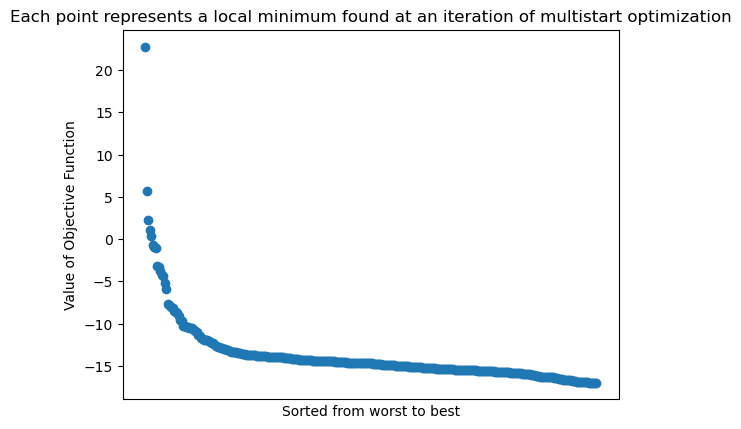

In [35]:
res, res_list_2 = multistart(gp_loss_fn, init_par_min, init_par_max, N = 300, full_output=True, args=(X,y), method = 'L-BFGS-B', jac = mll_gradient);
sigma_n, l, sigma, z = np.abs(res.x[0]), np.abs(res.x[1]), np.abs(res.x[2]), res.fun
print("Min of obj funct = ", z)
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plt.scatter(np.linspace(0, 1, len(res_list_2)), [res.fun for res in res_list_2]);
plt.title('Each point represents a local minimum found at an iteration of multistart optimization')
plt.xlabel('Sorted from worst to best')
plt.ylabel('Value of Objective Function')
plt.xticks([])
plt.gca().invert_xaxis()

Mean predictive std:  0.005303698382091834


<Figure size 640x480 with 0 Axes>

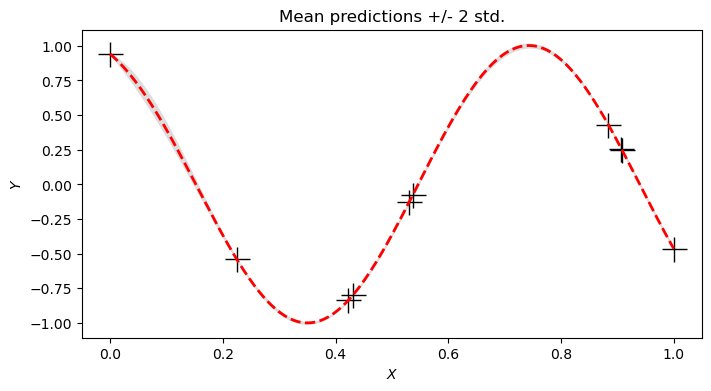

In [36]:
plot_post(X, y.T[0], sigma_n, l, sigma)

#### Strategy 4) Grid method for the negative marginal log likelihood

From the multi-start approach above we determined reasonable initial parameters for optimization. However, those initial parameters could lead to local minimums of the objective function rather than a global minimum. We thus use the initial parameters to create a grid of possible parameters tuples ($l$ and $\sigma_f$ in this case) over which we will optimize the objective function of our GP. For each iteration in the depth of the grid-optimization search, we narrow the dimensions of our new grid of possible parameter tuples. Once we're reasonablly close to the global minimum, we switch to a local optimization method to finish the job.

Min of obj funct =  -18.219056645209484
sigma_n = 0.000100, l = 0.280622, sigma_f = 1.289199
Mean predictive std:  0.0040579504565520065


<Figure size 640x480 with 0 Axes>

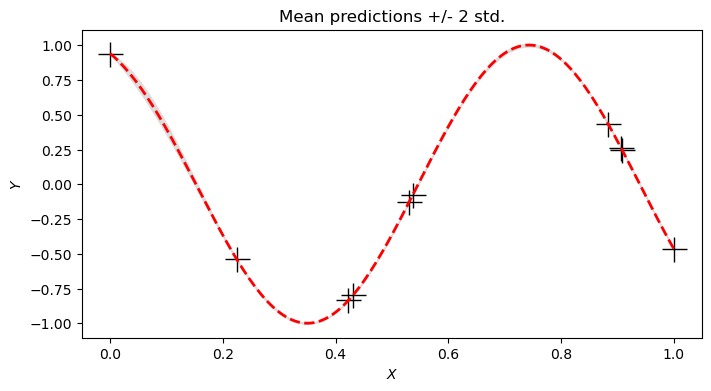

In [37]:
[[sigma_n, l, sigma, z], [z_plot, l_plot, sigma_plot, num_points, function]] = grid(gp_loss_fn, init_par, depth = 1, num_points = 300)
print("Min of obj funct = ", z)
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plot_post(X, y.T[0], sigma_n, l, sigma)

2D plot of the objective function of the GP with a squared exponential kernel against unkown hyperparameters $l$ and $\sigma_f$ (assuming $\sigma_n=0$). The red dot represents the global minimum of the objective function.

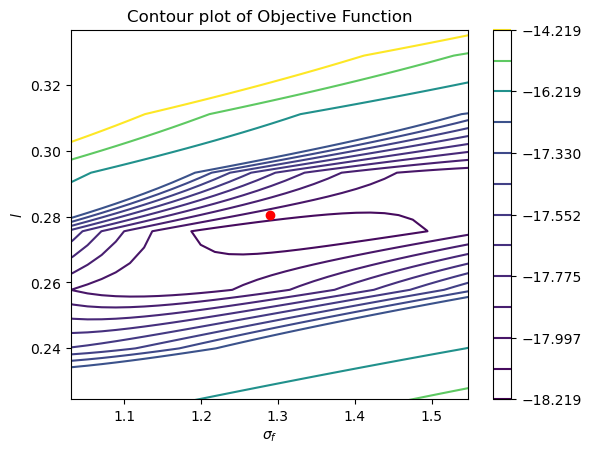

In [38]:
contour_plot([sigma_n, l, sigma, z], [z_plot, l_plot, sigma_plot, num_points, function])

3D plot of the negative marginal log likelihood

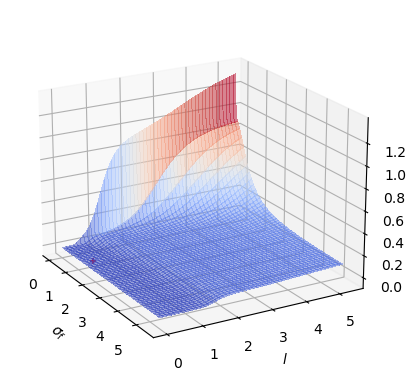

In [39]:
plot3D([sigma_n, l, sigma, z], [z_plot, l_plot, sigma_plot, num_points, function])

### Trust regions method

### Particle Swarm Optimization

https://en.wikipedia.org/wiki/Particle_swarm_optimization

https://nathanrooy.github.io/posts/2016-08-17/simple-particle-swarm-optimization-with-python/

https://pypi.org/project/pyswarms/

https://pyswarms.readthedocs.io/en/latest/    

### Scipy Global Optimization

https://docs.scipy.org/doc/scipy/tutorial/optimize.html#global-optimization